<a href="https://colab.research.google.com/github/Nicordaro/MML/blob/main/MML_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Mathematics in Machine Learning
#Tesina
Nicolò Cordaro s272145

---



###Organize imports and dataset definition

In [65]:
import os
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shutil
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Clone github repository with dataset
# deleting if already present(Only for development purposes, colab limitations)
!rm -rf MML
!rm -rf dataset
if not os.path.isdir('./MML'):
  !git clone https://github.com/Nicordaro/MML
    
source_dir = './MML/dataset'
target_dir = './dataset'
    
file_names = os.listdir(source_dir)
os.mkdir(target_dir)
for file_name in file_names:
  print(file_name)
  shutil.move(source_dir+"/"+file_name, target_dir+"/"+file_name)

Cloning into 'MML'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 31 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.
breast-cancer-wisconsin.names
breast-cancer-wisconsin.data


# Visualization

In [3]:
#@title
names = {"sampcode":"Sample code number", 
"clump": "Clump Thickness", 
"uni_size":"Uniformity of Cell Size", 
"uni_shape":"Uniformity of Cell Shape", 
"adhesion":"Marginal Adhesion", 
"epith_size":"Single Epithelial Cell Size", 
"nuclei":"Bare Nuclei", 
"chromatin":"Bland Chromatin", 
"nucleoli":"Normal Nucleoli", 
"mitoses":"Mitoses", 
"class":"Class"}


In [4]:
dataset_DF = pd.read_csv(target_dir+"/breast-cancer-wisconsin.data", names=list(names.keys()))
dataset_DF.iloc[:, 10] = dataset_DF.iloc[:, 10].replace(2, "benign").replace(4, "malign")
dataset_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sampcode    699 non-null    int64 
 1   clump       699 non-null    int64 
 2   uni_size    699 non-null    int64 
 3   uni_shape   699 non-null    int64 
 4   adhesion    699 non-null    int64 
 5   epith_size  699 non-null    int64 
 6   nuclei      699 non-null    object
 7   chromatin   699 non-null    int64 
 8   nucleoli    699 non-null    int64 
 9   mitoses     699 non-null    int64 
 10  class       699 non-null    object
dtypes: int64(9), object(2)
memory usage: 60.2+ KB


In [5]:
# Non-numerical values are present in the Bare-nuclei feature
dataset_DF.isin(['?']).any()

sampcode      False
clump         False
uni_size      False
uni_shape     False
adhesion      False
epith_size    False
nuclei         True
chromatin     False
nucleoli      False
mitoses       False
class         False
dtype: bool

In [6]:
# searching non-numeric ("?") occurrances in the dataset
dataset_DF = dataset_DF.drop(dataset_DF[dataset_DF["nuclei"]=="?"].index)
# conversion to numeric the object column
dataset_DF.iloc[:, 6] = pd.to_numeric(dataset_DF.iloc[:, 6])

In [7]:
print(dataset_DF.head(3))

   sampcode  clump  uni_size  uni_shape  ...  chromatin  nucleoli  mitoses   class
0   1000025      5         1          1  ...          3         1        1  benign
1   1002945      5         4          4  ...          3         2        1  benign
2   1015425      3         1          1  ...          3         1        1  benign

[3 rows x 11 columns]


In [8]:
#Rimozione della feature sampcode, non utile alla fine dell'analisi che si vuole portare avanti
dataset_DF = dataset_DF.drop("sampcode", axis=1)
print(dataset_DF.describe())

            clump    uni_size   uni_shape  ...   chromatin    nucleoli     mitoses
count  683.000000  683.000000  683.000000  ...  683.000000  683.000000  683.000000
mean     4.442167    3.150805    3.215227  ...    3.445095    2.869693    1.603221
std      2.820761    3.065145    2.988581  ...    2.449697    3.052666    1.732674
min      1.000000    1.000000    1.000000  ...    1.000000    1.000000    1.000000
25%      2.000000    1.000000    1.000000  ...    2.000000    1.000000    1.000000
50%      4.000000    1.000000    1.000000  ...    3.000000    1.000000    1.000000
75%      6.000000    5.000000    5.000000  ...    5.000000    4.000000    1.000000
max     10.000000   10.000000   10.000000  ...   10.000000   10.000000   10.000000

[8 rows x 9 columns]


In [9]:
# Description of only benign cancer occurances in the dataset
print(dataset_DF.loc[dataset_DF['class'] == "benign"].describe())

            clump    uni_size   uni_shape  ...   chromatin    nucleoli     mitoses
count  444.000000  444.000000  444.000000  ...  444.000000  444.000000  444.000000
mean     2.963964    1.306306    1.414414  ...    2.083333    1.261261    1.065315
std      1.672661    0.855657    0.957031  ...    1.062299    0.954606    0.509738
min      1.000000    1.000000    1.000000  ...    1.000000    1.000000    1.000000
25%      1.000000    1.000000    1.000000  ...    1.000000    1.000000    1.000000
50%      3.000000    1.000000    1.000000  ...    2.000000    1.000000    1.000000
75%      4.000000    1.000000    1.000000  ...    3.000000    1.000000    1.000000
max      8.000000    9.000000    8.000000  ...    7.000000    8.000000    8.000000

[8 rows x 9 columns]


In [10]:
# Description of only malign cancer occurances in the dataset
print(dataset_DF.loc[dataset_DF['class'] == "malign"].describe())

            clump    uni_size   uni_shape  ...   chromatin    nucleoli     mitoses
count  239.000000  239.000000  239.000000  ...  239.000000  239.000000  239.000000
mean     7.188285    6.577406    6.560669  ...    5.974895    5.857741    2.602510
std      2.437907    2.724244    2.569104  ...    2.282422    3.348876    2.564495
min      1.000000    1.000000    1.000000  ...    1.000000    1.000000    1.000000
25%      5.000000    4.000000    4.000000  ...    4.000000    3.000000    1.000000
50%      8.000000    6.000000    6.000000  ...    7.000000    6.000000    1.000000
75%     10.000000   10.000000    9.000000  ...    7.000000    9.500000    3.000000
max     10.000000   10.000000   10.000000  ...   10.000000   10.000000   10.000000

[8 rows x 9 columns]


In [11]:
encoded = pd.concat([dataset_DF.iloc[:, 0:9], dataset_DF["class"].replace("benign", 0).replace("malign", 1)], axis=1)
print(encoded)

     clump  uni_size  uni_shape  adhesion  ...  chromatin  nucleoli  mitoses  class
0        5         1          1         1  ...          3         1        1      0
1        5         4          4         5  ...          3         2        1      0
2        3         1          1         1  ...          3         1        1      0
3        6         8          8         1  ...          3         7        1      0
4        4         1          1         3  ...          3         1        1      0
..     ...       ...        ...       ...  ...        ...       ...      ...    ...
694      3         1          1         1  ...          1         1        1      0
695      2         1          1         1  ...          1         1        1      0
696      5        10         10         3  ...          8        10        2      1
697      4         8          6         4  ...         10         6        1      1
698      4         8          8         5  ...         10         4        1

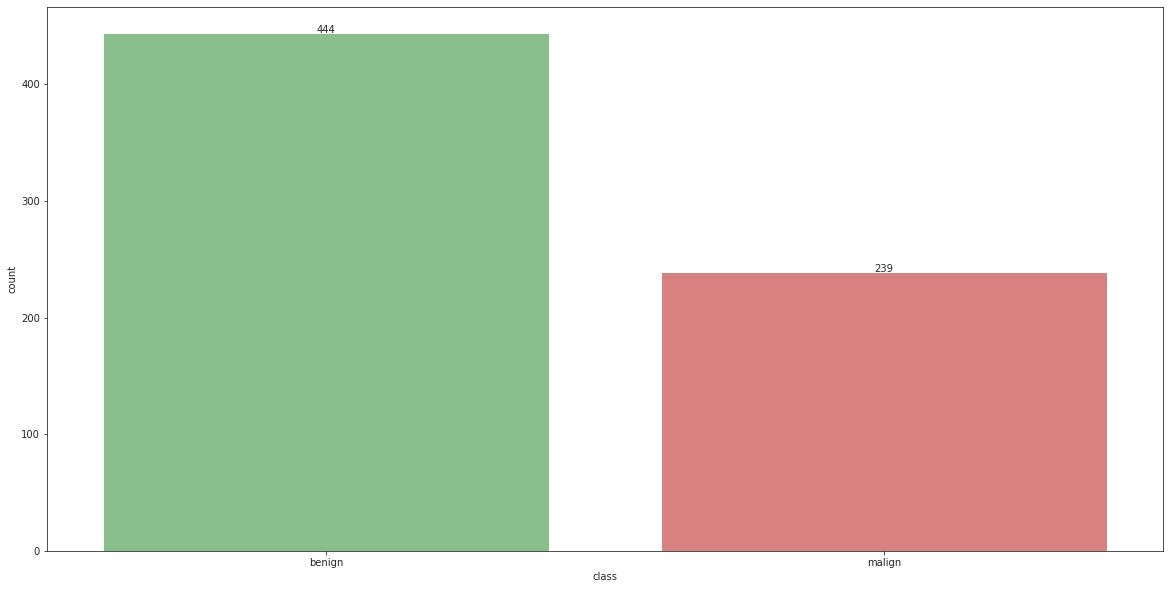

In [66]:
fig, ax1 = plt.subplots(figsize=(20,10), facecolor = "white")
col_dict = {"benign":"#81c784", "malign": "#e57373"}
graph = sns.countplot(dataset_DF["class"], palette=col_dict);
graph.set_xticklabels(graph.get_xticklabels())
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center");

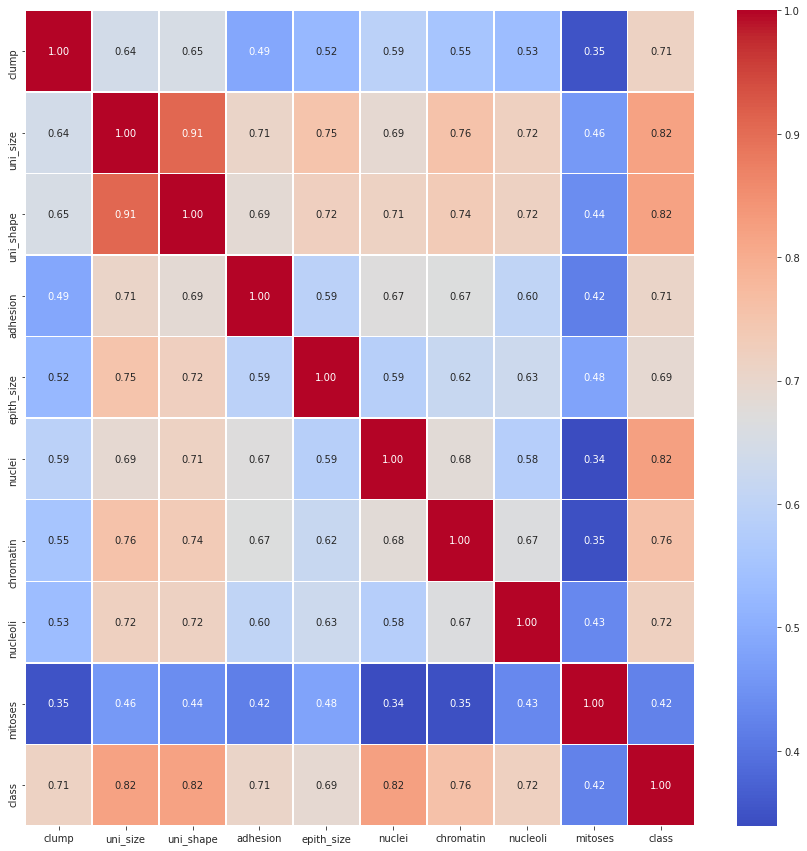

In [54]:
f,ax = plt.subplots(figsize=(15,15), facecolor="white")
sns.heatmap(encoded.corr(), annot=True, linewidths=0.5, fmt='.2f', cmap='coolwarm', ax=ax);

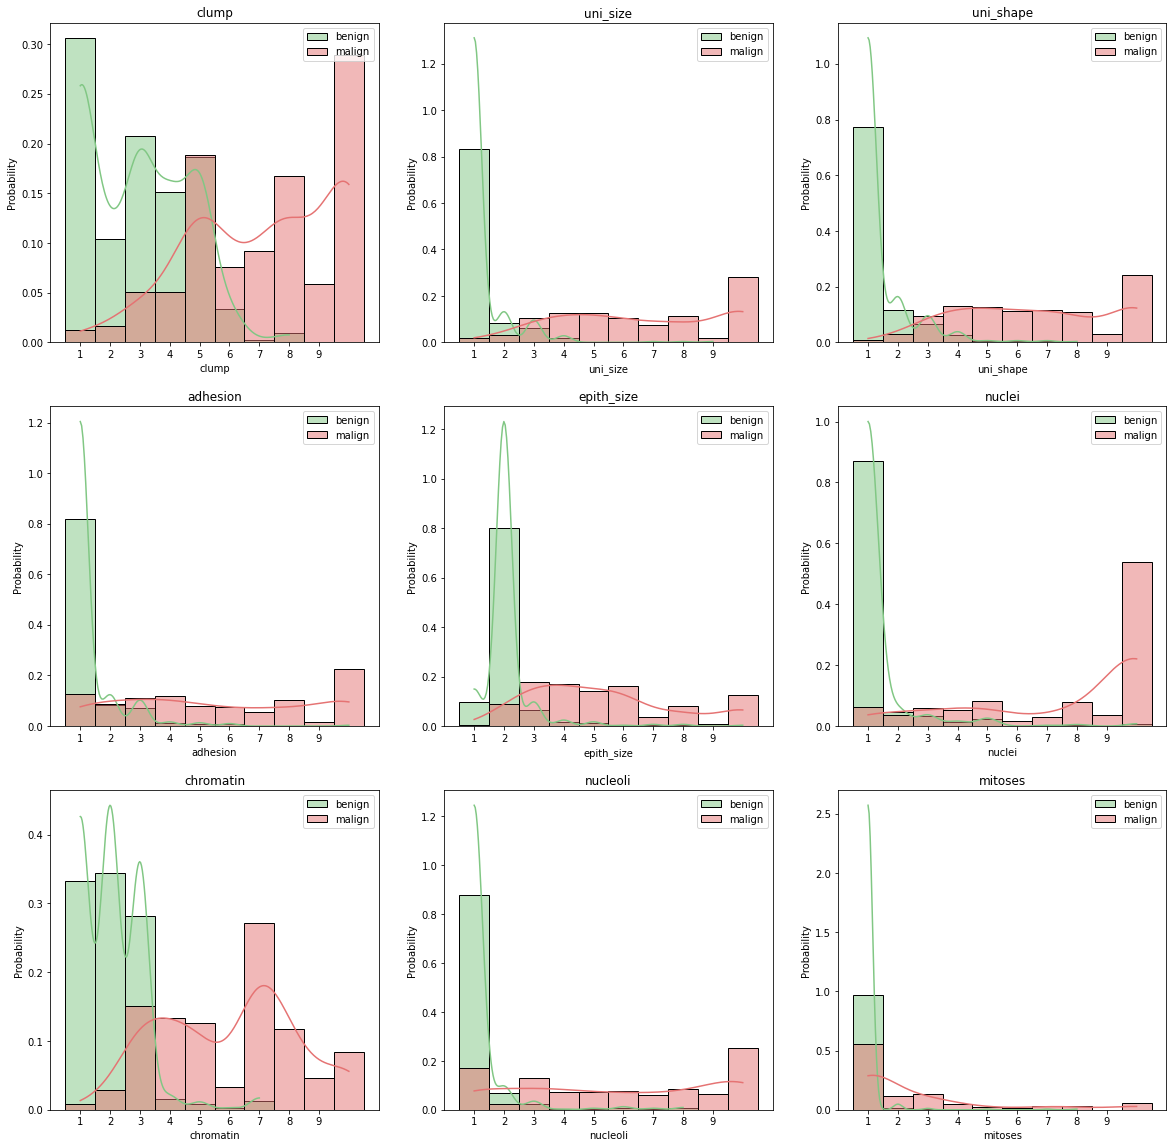

In [14]:
plt.subplots(3, 3, figsize = (20, 20), facecolor = "white")

for i, col in enumerate(dataset_DF.columns[:9]):
  plt.subplot(3, 3, i+1)
  sns.histplot(dataset_DF.loc[dataset_DF['class'] == 'benign', col], stat="probability", label='benign', color="#81c784", element="bars", discrete=True, kde=True)
  sns.histplot(dataset_DF.loc[dataset_DF['class'] == 'malign', col], stat="probability", label='malign', color="#e57373", element="bars", discrete=True, kde=True)
  plt.title(col)
  plt.xticks(np.arange(1,10,1))
  plt.legend(loc='upper right')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 28.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 68.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 63.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 67.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 65.8% of the points cannot be placed; y

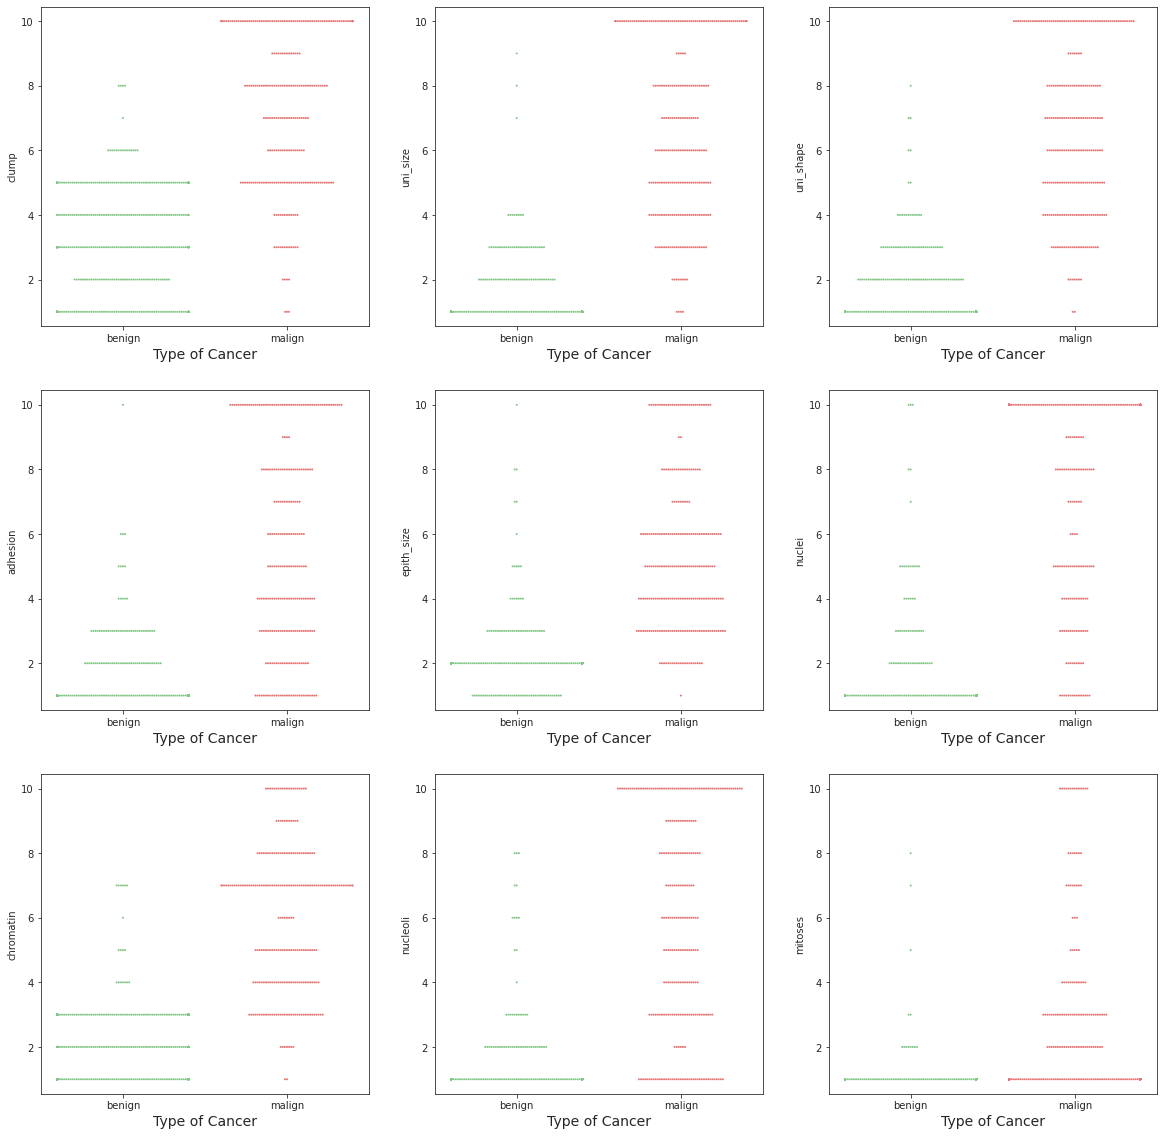

In [67]:
plt.subplots(3, 3, figsize = (20, 20), facecolor = "white")
for i, col in enumerate(dataset_DF.columns[:9]):
  plt.subplot(3, 3, i+1)
  sns.swarmplot(y=dataset_DF.iloc[:, i] , x="class", size=2, palette=col_dict, data=dataset_DF);
  plt.xlabel("Type of Cancer", size=14)

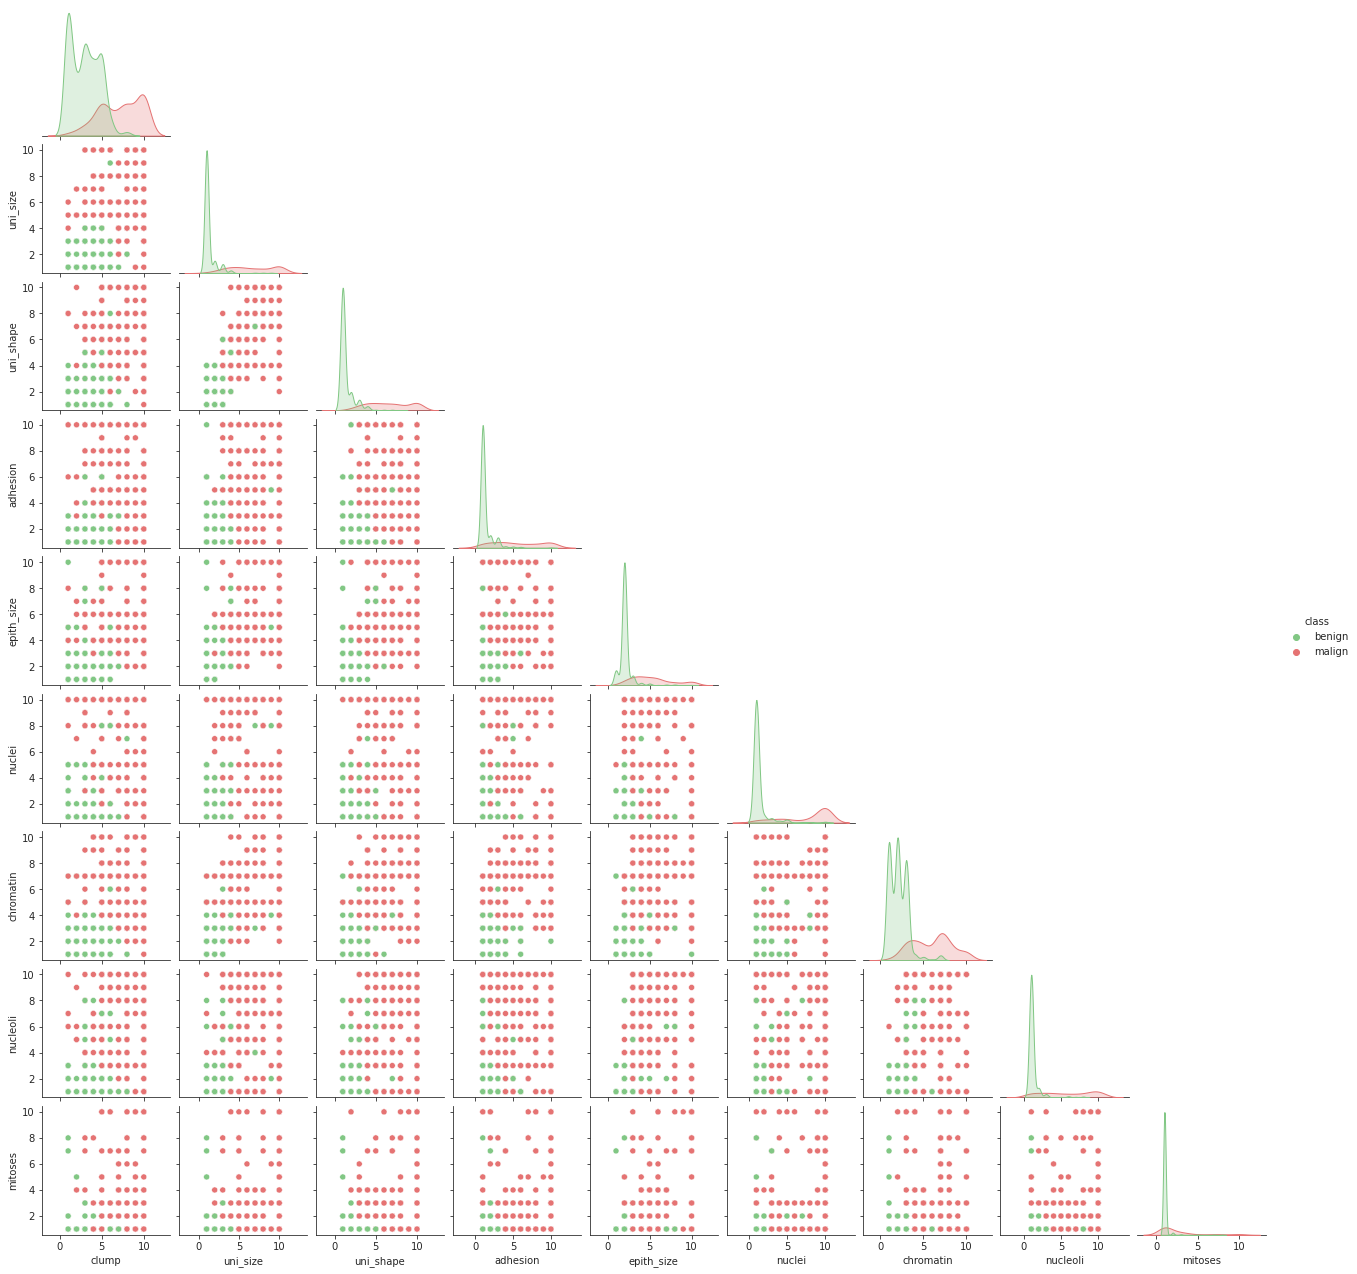

In [16]:
sns.set_style("ticks")
sns.pairplot(dataset_DF, hue = "class", diag_kind="kde", height=2, palette=col_dict)

In [24]:
#splitting data and target dataframe
x = encoded.iloc[:, :9]
y = encoded.iloc[:, 9]

seed = 42

In [25]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

x = pd.DataFrame(data=x, columns=['clump', 'uni_size', 'uni_shape',	'adhesion',	'epith_size',	'nuclei',	'chromatin', 'nucleoli',	'mitoses'])
x

,clump,uni_size,uni_shape,adhesion,epith_size,nuclei,chromatin,nucleoli,mitoses
0,0.444444,0.000000,0.000000,0.000000,0.111111,0.000000,0.222222,0.000000,0.000000
1,0.444444,0.333333,0.333333,0.444444,0.666667,1.000000,0.222222,0.111111,0.000000
2,0.222222,0.000000,0.000000,0.000000,0.111111,0.111111,0.222222,0.000000,0.000000
3,0.555556,0.777778,0.777778,0.000000,0.222222,0.333333,0.222222,0.666667,0.000000
4,0.333333,0.000000,0.000000,0.222222,0.111111,0.000000,0.222222,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
678,0.222222,0.000000,0.000000,0.000000,0.222222,0.111111,0.000000,0.000000,0.000000
679,0.111111,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000
680,0.444444,1.000000,1.000000,0.222222,0.666667,0.222222,0.777778,1.000000,0.111111
681,0.333333,0.777778,0.555556,0.333333,0.222222,0.333333,1.000000,0.555556,0.000000


[0.69050756 0.76245823 0.82301744 0.86743756 0.9064427  0.94088169
 0.96617646 0.98864155 1.        ]


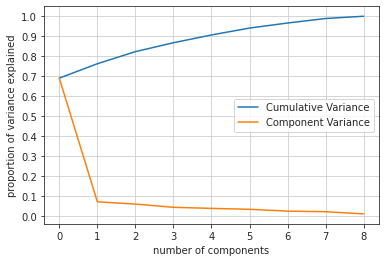

In [127]:

from sklearn.decomposition import PCA

pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('proportion of variance explained');
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.legend(['Cumulative Variance', 'Component Variance'])
print(np.cumsum(pca.explained_variance_ratio_))


In [29]:
pca = PCA(n_components = 4)
x_pca = pca.fit_transform(x)

In [33]:
x_pca_DF = pd.DataFrame(data=x_pca)
x_pca_DF

,0,1,2,3
0,-0.498011,0.002669,-0.190937,0.007930
1,0.535517,-0.526637,0.111954,0.076919
2,-0.514773,-0.067726,0.008778,-0.035238
3,0.566282,0.376289,-0.240143,-0.176851
4,-0.457381,-0.010985,0.009033,0.090300
...,...,...,...,...
678,-0.551931,-0.047364,-0.014907,-0.005097
679,-0.661830,0.025287,0.065863,0.001403
680,1.140065,0.808050,0.056672,-0.124801
681,0.711241,0.277753,0.204041,-0.050092


In [41]:
X_train_val, X_test, y_train_val, y_test = train_test_split(x_pca, y, test_size=0.30, random_state=42,stratify=y)

In [123]:
#To avoid overfitting we use KFold Stratified (stratidication given class imbalance)
# Some classification problems can exhibit a large imbalance in the distribution of the target classes: for instance there could be several times more negative samples than positive samples. 
# In such cases it is recommended to use stratified sampling as implemented in StratifiedKFold and StratifiedShuffleSplit to ensure that relative class frequencies is approximately preserved in each train and validation fold.


kf = StratifiedKFold(n_splits=20, shuffle=True)

# StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

scores = []
for train_index, test_index in kf.split(X_train_val,y_train_val):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = X_train_val[train_index], X_train_val[test_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]
    
    #SMOTE
    sm = SMOTE(random_state=SEED)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    #print("num_malign")
    #print(y_res.tolist().count(1))
    #print("num_benign")
    #print(y_res.tolist().count(0))
    #Classification
    clf = DecisionTreeClassifier(criterion='gini')
    clf.fit(X_res,y_res)
    pred = clf.predict(X_val)
    scores.append(f1_score(pred,y_val))
print(f"mean score {np.mean(scores)}")

mean score 0.9521012089046146


In [115]:
# results on the test set
clf = DecisionTreeClassifier(criterion='gini')
sm = SMOTE(random_state=SEED)
X_res, y_res = sm.fit_resample(X_train_val, y_train_val)
clf.fit(X_res,y_res)
pred = clf.predict(X_test)
print(f"Accuracy = {accuracy_score(pred,y_test)}")
print(f"F1 = {f1_score(pred,y_test)}")
print(f"Precision = {precision_score(pred,y_test)}")
print(f"Recall = {recall_score(pred,y_test)}")

Accuracy = 0.9658536585365853
F1 = 0.9523809523809524
Precision = 0.9722222222222222
Recall = 0.9333333333333333


In [116]:
def confmat(y_test,pred):
    cf_matrix = confusion_matrix(y_test, pred)
    ax = sns.heatmap(cf_matrix, annot=True,  fmt='g', cmap='coolwarm', xticklabels=["benign","malign"], yticklabels=["benign","malign"]) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set(xlabel='True Label', ylabel='Predicted Label')

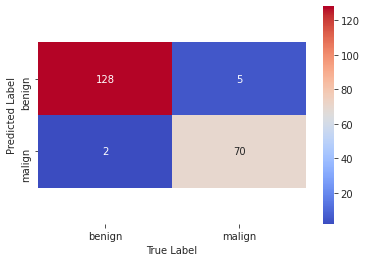

In [117]:
confmat(y_test,pred)